In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random_state = 42
# np.random.seed = random_state
rng = np.random.default_rng(random_state)

In [3]:
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                    names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [4]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


missing values

In [5]:
iris.isna().sum().sum()

0

In [6]:
# split the dataset into train and test
from sklearn.model_selection import train_test_split

train, test = train_test_split(iris, test_size=0.2, stratify=iris['species'], random_state=random_state)

In [7]:
y_col = 'species'

we don't look at testset

In [8]:
train.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,120.000000,120.000000,120.000000,120.000000
mean,5.841667,3.044167,3.770833,1.204167
std,0.840926,0.445669,1.767417,0.763825
min,4.300000,2.000000,1.100000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.750000,3.000000,4.250000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


but, it's okay to look at the population distribution of the entire dataset(including testset)

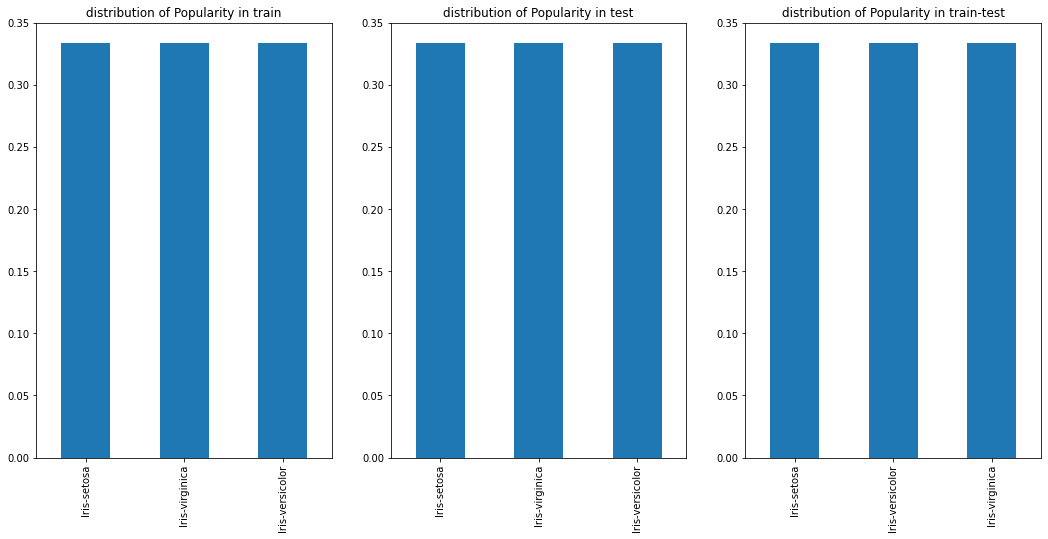

In [9]:
# target distribution in percentage
_, axs = plt.subplots(1, 3, figsize=(18, 8))
train[y_col].value_counts(normalize=True).plot(kind="bar", title="distribution of Popularity in train", ax=axs[0])
test[y_col].value_counts(normalize=True).plot(kind="bar", title="distribution of Popularity in test", ax=axs[1])
iris[y_col].value_counts(normalize=True).plot(kind="bar", title="distribution of Popularity in train-test", ax=axs[2])
plt.show()

population is normally distributed: no target imbalance

# EDA

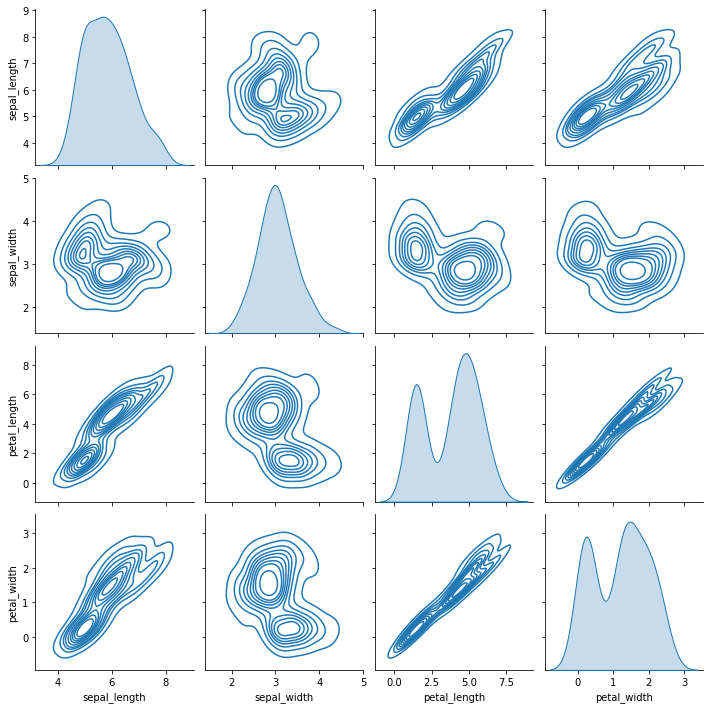

In [10]:
# Use Pairplot to understand relationships among paramaters
_ = sns.pairplot(train, kind='kde', markers='*')
plt.show()

can't see any significant outliers that would skew the distributions

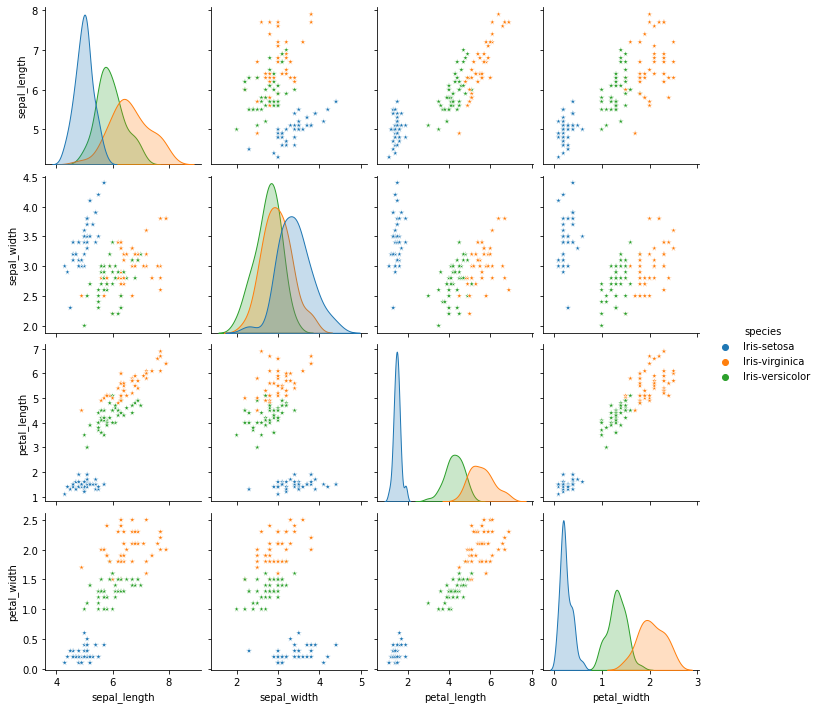

In [11]:
# Use Pairplot to understand relationships among paramaters
_ = sns.pairplot(train, hue='species', markers='*')
plt.show()

* Because Patel length and Petal width have saperable distributions for different iris species, these 2 variables would have higher influence over classifying the species. 
* We can also observe from the scatterplots of `petal_length` x `petal_width`, `petal_width` x `sepal_width` and `petal_width` x `sepal_length`, that the species clusters are clearly distinguishable and can easily be saperated a line. 
* Hence, a sinple linear model(s) would be best suited for this type of classification here, without requiring of any feature transformations as the features are already distinguishable.
* The setosa species is the most easily distinguishable because of its small feature size.

In [12]:
def plot_heatmap(matrix, size=10, title=None):
    labels = matrix.applymap(lambda v: str(np.round(v, decimals=2)) if 1 > np.abs(v) >= .5 else '')
    mask = np.zeros_like(matrix)
    mask[np.tril_indices_from(mask)] = True
    sns.clustermap(matrix, center=0, cmap='vlag', linewidth=1, annot=labels, fmt='')
    plt.title(title)
    plt.show()

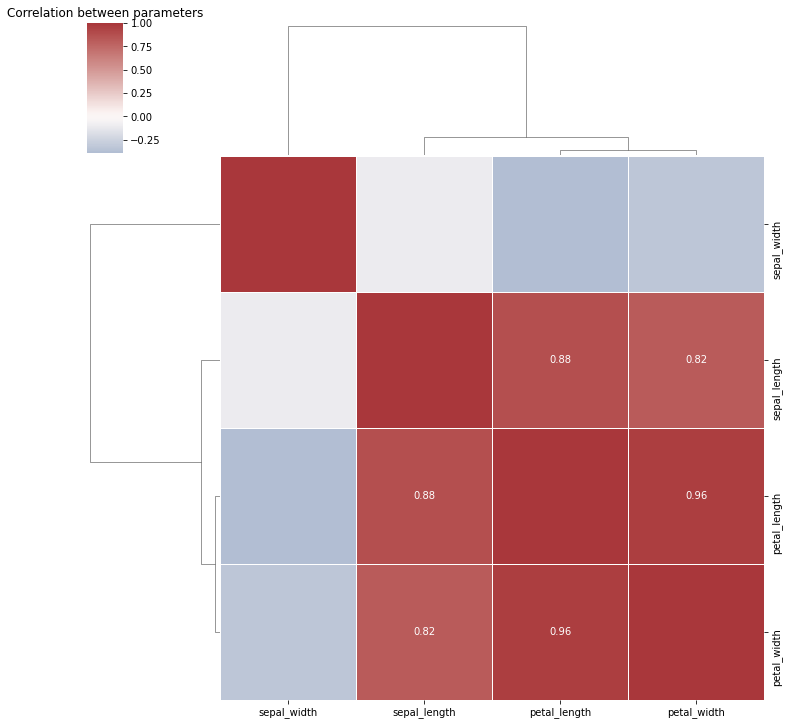

In [13]:
# plot heatmap of correlation between parameters and show only the upper triangle
plot_heatmap(train.corr(), title='Correlation between parameters')

* if we look further we can see that `petal_width` is highly +vely correlated to `petal_length` and `sepal_length`. Similarly, `petal_length` and `sepal_length` are also sognificantly correlated.
* Also, `sepal_width` is slightly -vely correlated with other variables.

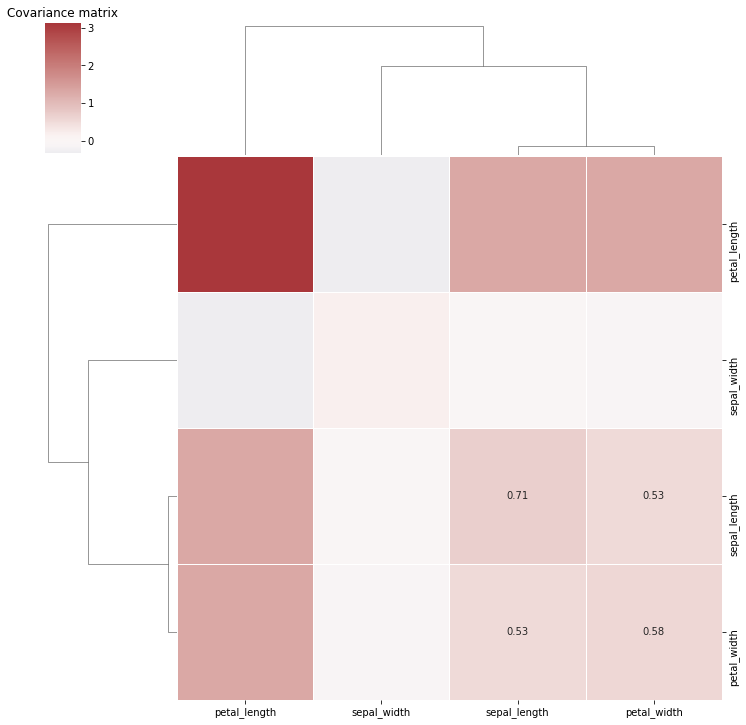

In [14]:
# compute covariance matrix
cov_matrix = np.cov(train.drop('species', axis=1).T)
cov_matrix = pd.DataFrame(cov_matrix, columns=train.columns[:-1], index=train.columns[:-1])
plot_heatmap(cov_matrix, title='Covariance matrix')

A strong correlation is present between petal width and petal length.

# Modeling

we earlier found out that the dataset is not too complex and simple models(most probably linear models) would be better suited for this problem.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.drop(y_col, axis=1), iris[y_col], test_size=0.2, random_state=random_state, stratify=iris[y_col])

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.1, 1, 10, 100], 
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    # 'l1_ratio': [0, 0.1, 0.5, 0.9, 1]
    }

logreg = LogisticRegression(tol=1e-6, fit_intercept=True, n_jobs=-1, verbose=0)
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

/home/abhinav/Documents/my-portfolio-projects/machine learning projects/iris-flowers/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/abhinav/Documents/my-portfolio-projects/machine learning projects/iris-flowers/env/lib/python3.9/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/home/abhinav/Documents/my-portfolio-projects/machine learning projects/iris-flowers/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/abhinav/Documents/my-portfolio-projects/machine learning projects/iris-flowers/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, tol=1e-06),
             param_grid={'C': [0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [23]:
grid.best_params_

{'C': 0.1, 'penalty': 'none', 'solver': 'saga'}

In [18]:
grid.best_score_

0.9833333333333334

In [19]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve

print(classification_report(y_test, grid.predict(X_test)))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



In [20]:
def plot_confusion_matrix(y_true, y_pred, classes, title, normalize='true'):
    """
    Plot the confusion matrix of the model.
    Parameters
    ----------
    y_true: np.array
        The true target of the dataset.
    y_pred: np.array
        The predicted target of the dataset.
    classes: np.array
        The classes of the dataset.
    title: str
        The title of the plot.
    regr: bool, optional
        If True, the confusion matrix is computed as the mean of the errors (MSE, i.e. Mean Squared Errors).
        Otherwise, the confusion matrix is computed as the mean of the accuracies (i.e. Accuracy).
        By default, it is True.
    cmap: matplotlib.colors.Colormap, optional
        The colormap used to plot the confusion matrix.
    Returns
    -------
    None
    """

    # Compute confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=classes,
        # cmap=cmap,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

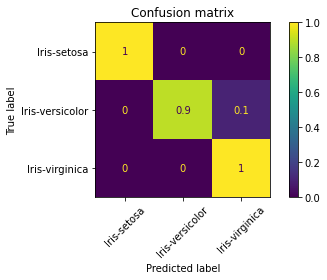

In [21]:
plot_confusion_matrix(y_test, grid.predict(X_test), classes=iris[y_col].unique(), title='Confusion matrix')

I don't think any explanation is needed at this point.